In [16]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 20]

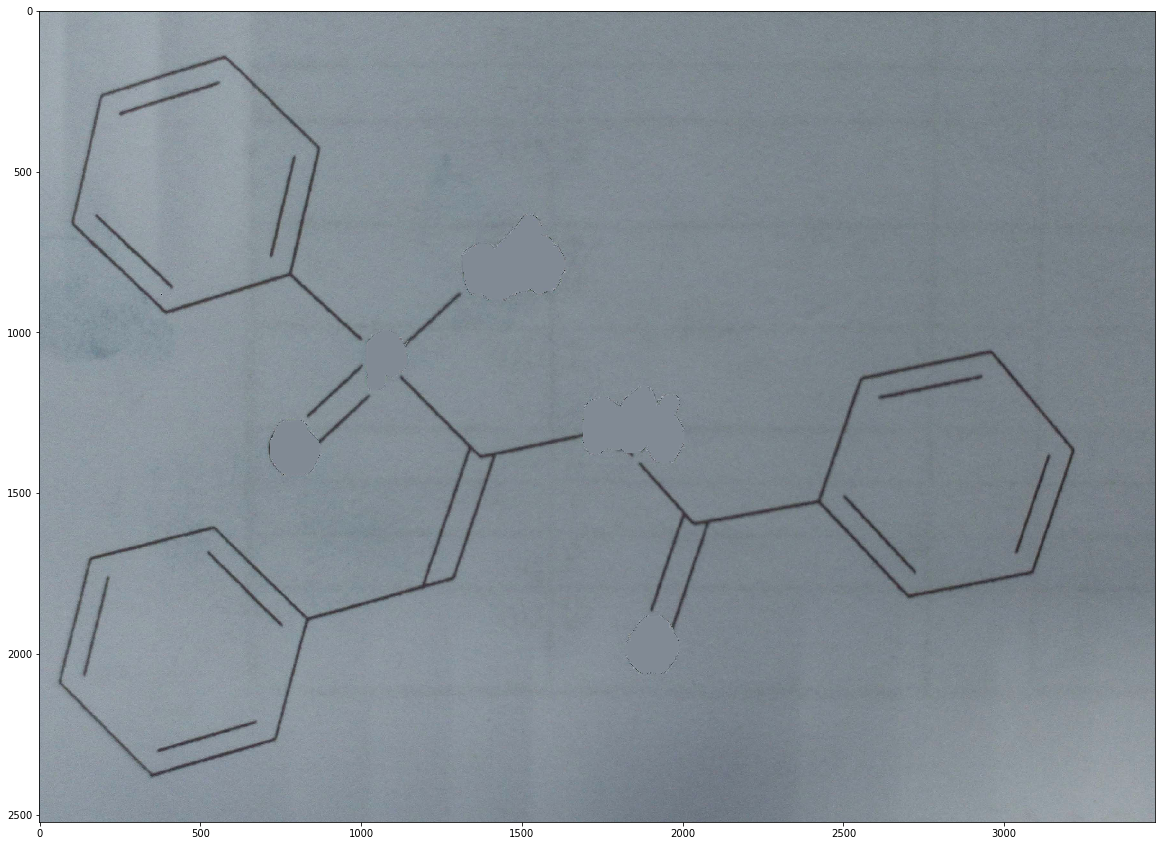

In [17]:
img = cv2.imread('mol.jpg')
plt.imshow(img)

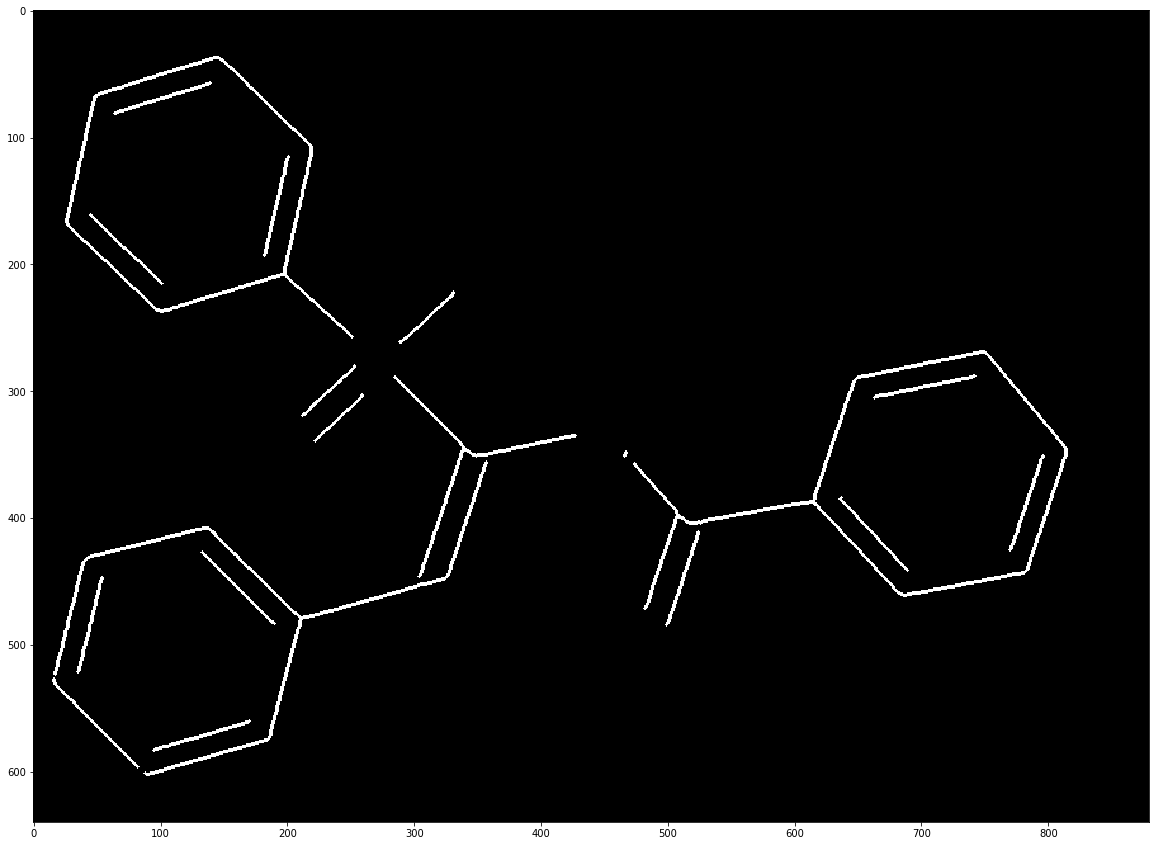

In [18]:
def preprocess(img, height=640, kernel_1=9, kernel_2=3):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    scale = height / gray_img.shape[0]
    gray_img = cv2.resize(gray_img, (int(gray_img.shape[1] * scale), height))

    gray_img = cv2.GaussianBlur(gray_img, (kernel_1, kernel_1), 0)
    gray_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 11, 9)
    gray_img = 1 - cv2.GaussianBlur(gray_img, (kernel_2, kernel_2), 0) // 255

    gray_img = (skeletonize(gray_img) * 255).astype('uint8')
    kernel = np.array([[0, 1, 0],
                       [1, 1, 1],
                       [0, 1, 0]], dtype='uint8')
    gray_img = cv2.dilate(gray_img, kernel)
    return gray_img

gray_img = preprocess(img)
plt.imshow(gray_img, cmap='gray')

In [19]:
def angle(line1, line2):
    d1 = (line1[3] - line1[1]) / (line1[2] - line1[0] + 0.1)
    d2 = (line2[3] - line2[1]) / (line2[2] - line2[0] + 0.1)
    angle = abs(math.atan(d1) - math.atan(d2)) * 180 / np.pi

    return min(angle, 180 - angle)

In [20]:
def distance(point1, point2):
    return math.sqrt((point1[1] - point2[1]) ** 2 + (point1[0] - point2[0]) ** 2)

In [21]:
def line_len(line):
    return distance((line[0], line[1]), (line[2], line[3]))

In [22]:
def center_distance(line1, line2):
    center1 = ((line1[2] + line1[0]) / 2, (line1[3] + line1[1]) / 2)
    center2 = ((line2[2] + line2[0]) / 2, (line2[3] + line2[1]) / 2)
    return math.sqrt((center2[0] - center1[0]) ** 2 + (center2[1] - center1[1]) ** 2)

In [23]:
def lines_distance(line1, line2):
    point = np.array([(line2[0] + line2[2]) // 2, (line2[1] + line2[3]) // 2])
    line1_start = np.array([line1[0], line1[1]])
    line1_end = np.array([line1[2], line1[3]])
    return np.abs(np.cross(line1_end - line1_start, line1_start - point)) /\
        np.linalg.norm(line1_end - line1_start)

In [24]:
def lines_union(line1, line2):
    points = np.array([[line1[0], line1[1]],
                       [line1[2], line1[3]],
                       [line2[0], line2[1]],
                       [line2[2], line2[3]]])
    max_dist = -1
    max_i = -1
    max_j = -1
    for i in range(4):
        for j in range(i + 1, 4):
            dist = distance(points[i], points[j])
            if dist > max_dist:
                max_dist = dist
                max_i = i
                max_j = j
    return np.array([*points[max_i], *points[max_j]])

In [25]:
def get_raw_lines(img,
                  rho=1,
                  theta=np.pi / 180,
                  threshold=30,
                  min_line_length=20,
                  max_line_gap=20):
    return cv2.HoughLinesP(gray_img, rho, theta, threshold, np.array([]),
                           min_line_length, max_line_gap)

In [26]:
def get_unique_lines(lines):
    unique_lines = []
    for i in range(lines.shape[0]):
        for j in range(i + 1):
            if j >= len(unique_lines):
                unique_lines.append(lines[i][0])
                break
            line1 = lines[i][0]
            line2 = unique_lines[j]

            if line_len(line2) > line_len(line1):
                line1, line2 = line2, line1

            if angle(line1, line2) < 15:
                if lines_distance(line1, line2) < 10 and\
                        center_distance(line1, line2) < line_len(line1) / 2:
                    unique_lines[j] = lines_union(line1, line2)
                    break

    median_len = np.median([line_len(line) for line in unique_lines])
    unique_lines = list(filter(lambda line: line_len(line) > (median_len / 3),
                               unique_lines))
    return np.array(unique_lines)

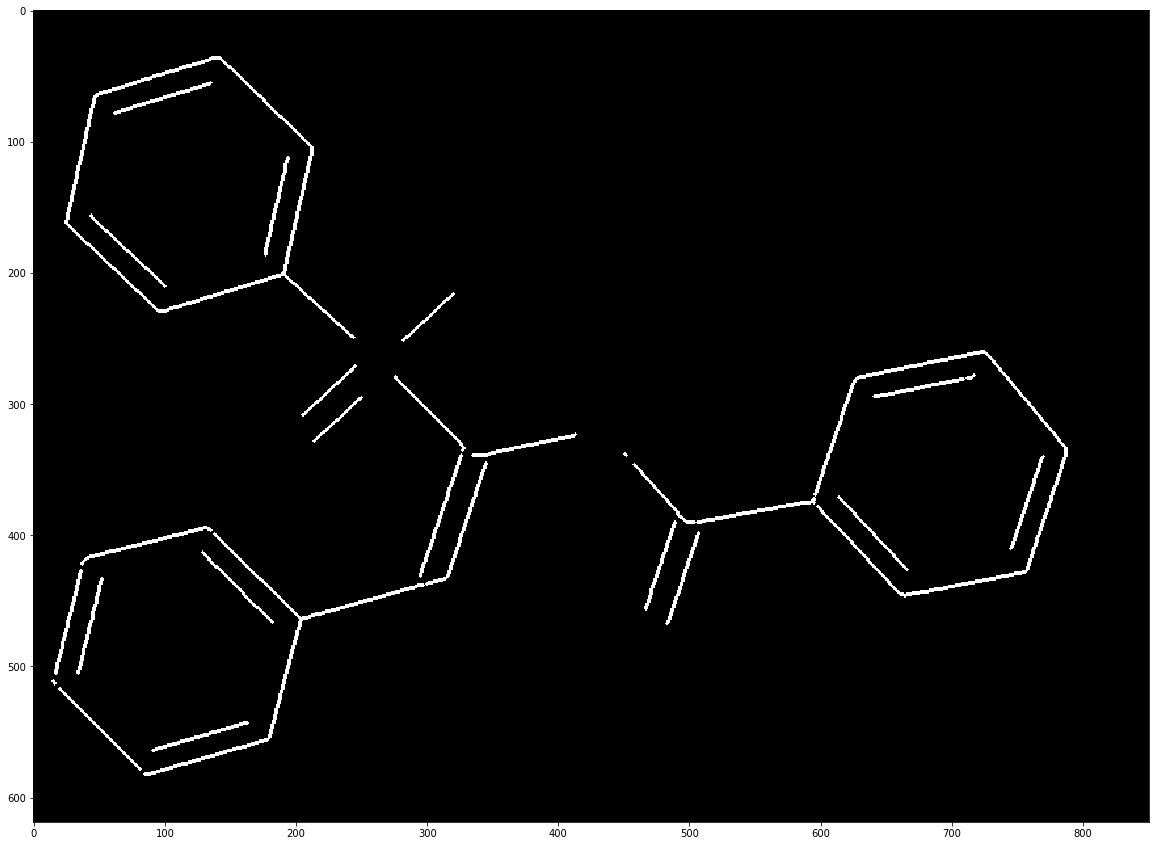

In [27]:
plt.gca().set_aspect('equal', adjustable='box')
default_median = 100.0
lines = get_unique_lines(get_raw_lines(gray_img))
median_length = np.median([line_len(line) for line in lines])
scale = median_length / default_median

gray_img = preprocess(img, height=int(640 / scale), kernel_1=9, kernel_2=1)
plt.imshow(gray_img, cmap='gray')

In [28]:
final_lines = get_unique_lines(get_raw_lines(gray_img, max_line_gap=20, min_line_length=20))

True

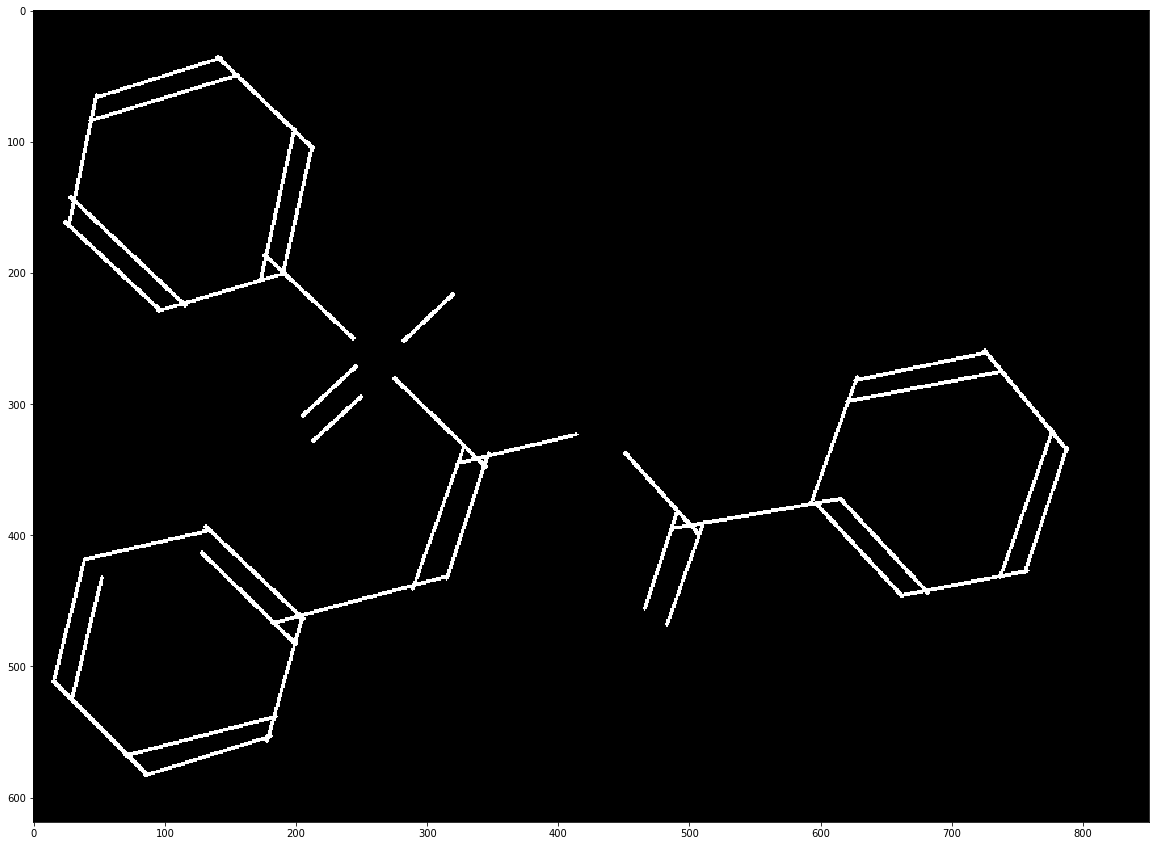

In [29]:
line_image = np.copy(gray_img) * 0  # creating a blank to draw lines on

for line in final_lines:
    x1,y1,x2,y2 = line
    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(line_image, cmap='gray')
cv2.imwrite('xep_processed1.png', line_image)

In [30]:
final_lines

array([[626, 282, 725, 261],
       [ 40, 418, 135, 396],
       [275, 280, 345, 348],
       [661, 446, 758, 427],
       [213, 105, 140,  35],
       [ 15, 511,  87, 583],
       [316, 431, 182, 467],
       [ 27, 163,  48,  64],
       [486, 395, 616, 372],
       [289, 441, 328, 333],
       [ 85, 583, 181, 553],
       [ 15, 512,  39, 418],
       [ 70, 568, 185, 538],
       [788, 335, 725, 259],
       [131, 393, 206, 464],
       [ 95, 229, 192, 200],
       [788, 333, 756, 428],
       [628, 279, 593, 375],
       [315, 433, 347, 337],
       [143,  36,  48,  66],
       [190, 201, 212, 105],
       [ 24, 161,  96, 228],
       [596, 375, 661, 445],
       [ 28, 142, 116, 225],
       [176, 186, 244, 250],
       [ 43,  84, 156,  49],
       [737, 432, 777, 320],
       [178, 557, 205, 462],
       [320, 216, 282, 252],
       [173, 206, 199,  90],
       [414, 323, 323, 345],
       [738, 275, 620, 298],
       [615, 372, 682, 444],
       [483, 468, 511, 390],
       [491, 3